In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sohansakib75/pmrambrain")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pmrambrain


In [2]:
import os

for root, dirs, files in os.walk("/kaggle/input/pmrambrain"):
    for d in dirs:
        print(os.path.join(root, d))


/kaggle/input/pmrambrain/Raw
/kaggle/input/pmrambrain/Raw/512Glioma
/kaggle/input/pmrambrain/Raw/512Meningioma
/kaggle/input/pmrambrain/Raw/512Pituitary
/kaggle/input/pmrambrain/Raw/512Normal



Class: 512Glioma, Image: glioma (123).jpg


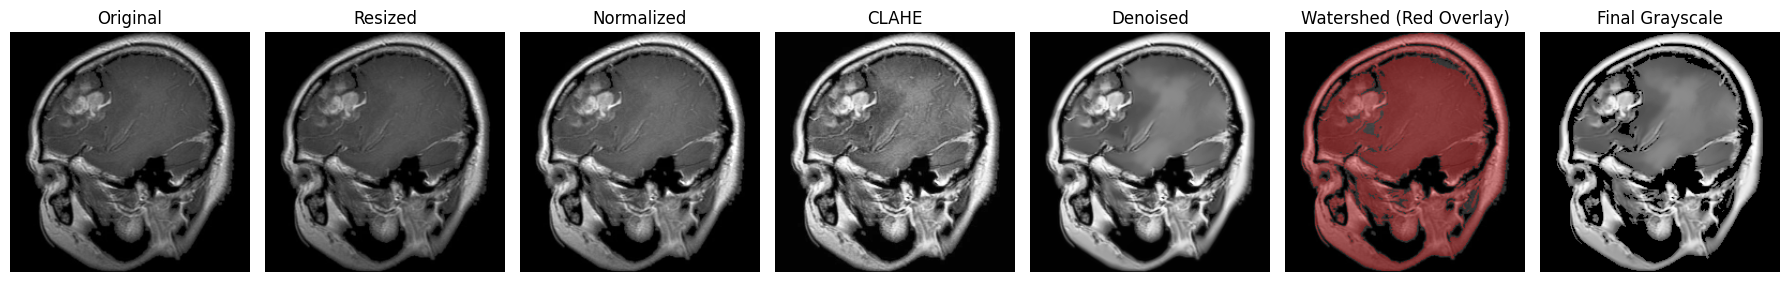


Class: 512Meningioma, Image: M_187.jpg


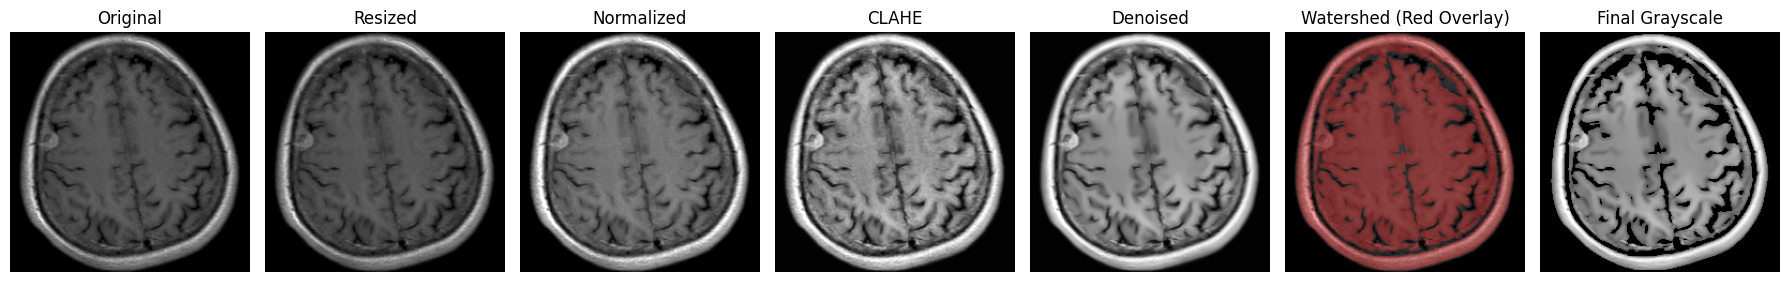


Class: 512Pituitary, Image: pituitary (205).jpg


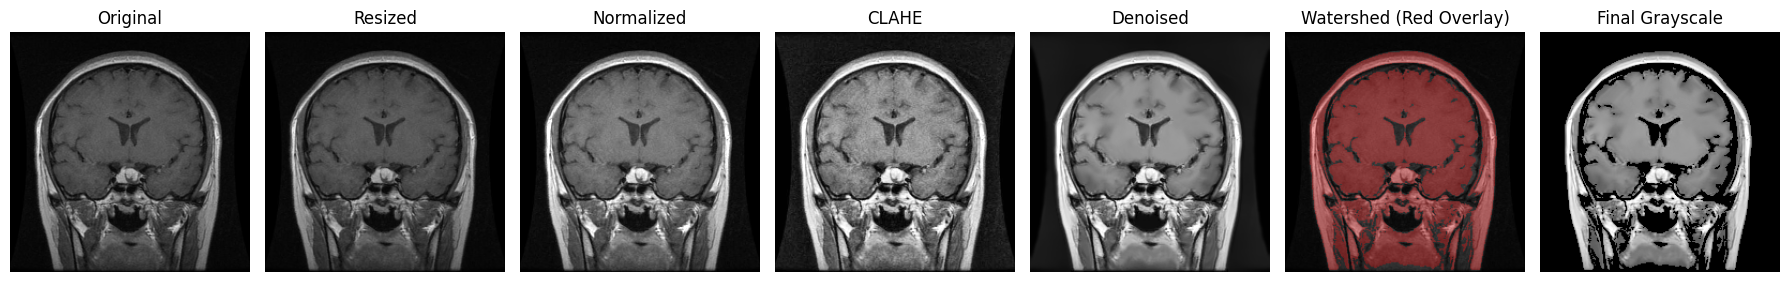


Class: 512Normal, Image: normal (279).jpg


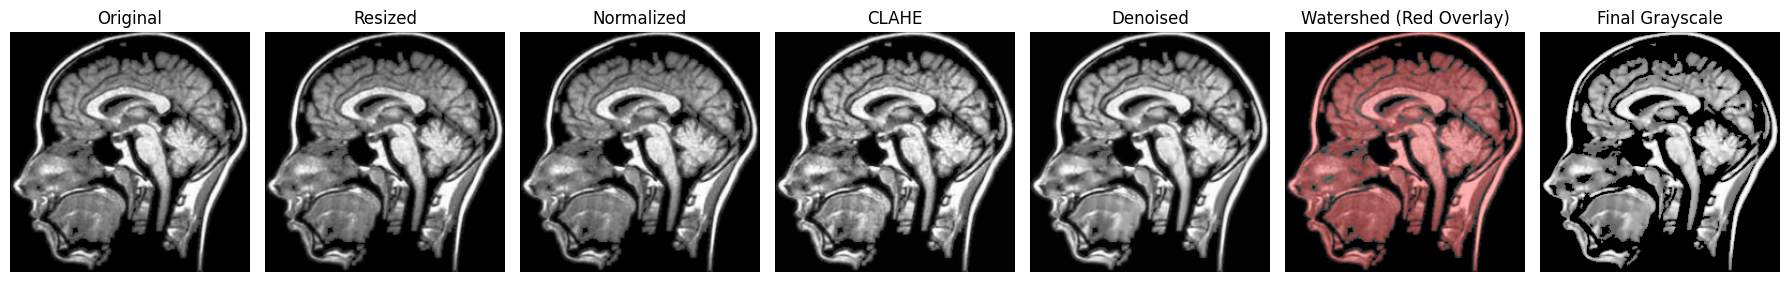


Starting batch preprocessing & saving all images...

All images preprocessed and saved in /kaggle/working/preprocessed/


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

# Paths and params
base_path = "/kaggle/input/pmrambrain/Raw"
output_base = "/kaggle/working/preprocessed"
class_dirs = ["512Glioma", "512Meningioma", "512Pituitary", "512Normal"]
img_size = (224, 224)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_image(path, img):
    cv2.imwrite(path, img)

def show_images(images, titles):
    plt.figure(figsize=(18, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def preprocess_image(img):
    results = {}

    # Step 1: Resize
    img_resized = cv2.resize(img, img_size)
    results['resized'] = img_resized

    # Step 2: Z-score normalization (grayscale)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_norm = (img_gray - np.mean(img_gray)) / (np.std(img_gray) + 1e-8)
    img_norm = np.clip(img_norm, -3, 3)
    img_norm = ((img_norm - img_norm.min()) / (img_norm.max() - img_norm.min()) * 255).astype(np.uint8)
    results['normalized'] = img_norm

    # Step 3: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_norm)
    results['clahe'] = img_clahe

    # Step 4: Denoising
    img_denoised = cv2.fastNlMeansDenoising(img_clahe, h=10, templateWindowSize=7, searchWindowSize=21)
    results['denoised'] = img_denoised

    # Step 5: Watershed mask
    ret, thresh = cv2.threshold(img_denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    distance = ndi.distance_transform_edt(thresh)

    coordinates = peak_local_max(distance, labels=thresh, footprint=np.ones((3, 3)))
    markers = np.zeros_like(distance, dtype=int)
    for i, coord in enumerate(coordinates, 1):
        markers[coord[0], coord[1]] = i

    labels = watershed(-distance, markers, mask=thresh)

    # Watershed mask (boolean)
    watershed_mask = (labels > 0)

    # Colored overlay in red on original resized image
    img_color = img_resized.copy()
    overlay = img_color.copy()
    overlay[watershed_mask] = [0, 0, 255]  # Red in BGR
    img_watershed = cv2.addWeighted(img_color, 0.7, overlay, 0.3, 0)
    results['watershed_color'] = img_watershed

    # Final grayscale preprocessed image = denoised image masked by watershed mask
    img_final_gray = cv2.bitwise_and(img_denoised, img_denoised, mask=watershed_mask.astype(np.uint8)*255)
    results['final_grayscale'] = img_final_gray

    return results

# Visualize and save images for one example per class
for class_name in class_dirs:
    class_path = os.path.join(base_path, class_name)
    save_class_base = os.path.join(output_base, class_name)
    sample_image_name = next((f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))), None)
    
    if sample_image_name:
        img_path = os.path.join(class_path, sample_image_name)
        img = cv2.imread(img_path)  # Read as color BGR
        print(f"\nClass: {class_name}, Image: {sample_image_name}")

        processed_imgs = preprocess_image(img)

        # Show preprocessing steps including watershed color overlay
        show_images(
            [img, processed_imgs['resized'], processed_imgs['normalized'], processed_imgs['clahe'], 
             processed_imgs['denoised'], processed_imgs['watershed_color'], processed_imgs['final_grayscale']],
            ['Original', 'Resized', 'Normalized', 'CLAHE', 'Denoised', 'Watershed (Red Overlay)', 'Final Grayscale']
        )

        # Save all preprocessed images for this class (one sample)
        for step_name, proc_img in processed_imgs.items():
            save_folder = os.path.join(save_class_base, step_name)
            ensure_dir(save_folder)
            save_path = os.path.join(save_folder, os.path.splitext(sample_image_name)[0] + '.png')
            save_image(save_path, proc_img)

# Batch preprocess and save all images (comment out to speed up)
print("\nStarting batch preprocessing & saving all images...")

for class_name in class_dirs:
    class_path = os.path.join(base_path, class_name)
    save_class_base = os.path.join(output_base, class_name)

    for filename in os.listdir(class_path):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path)  # Read as color BGR

        processed_imgs = preprocess_image(img)
        for step_name, proc_img in processed_imgs.items():
            save_folder = os.path.join(save_class_base, step_name)
            ensure_dir(save_folder)
            save_path = os.path.join(save_folder, os.path.splitext(filename)[0] + '.png')
            save_image(save_path, proc_img)

print("\nAll images preprocessed and saved in /kaggle/working/preprocessed/")


In [5]:
import os
import cv2
import numpy as np
import shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Setup paths and classes ===
class_dirs = ["512Glioma", "512Meningioma", "512Pituitary", "512Normal"]
preprocessed_path = "/kaggle/working/preprocessed"
augmented_base = "/kaggle/working/augmented"
split_base = "/kaggle/working/split_augmented"
img_size = (224, 224)
batch_size = 32

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# === Image Augmentation Function ===
def augment_image(img):
    augmented = []

    # Horizontal flip
    augmented.append(cv2.flip(img, 1))

    # Small rotation
    center = tuple(int(x) for x in np.array(img.shape[1::-1]) // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle=10, scale=1.0)
    rotated = cv2.warpAffine(img, rot_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    augmented.append(rotated)

    # Brightness and contrast
    bright_contrast = cv2.convertScaleAbs(img, alpha=1.2, beta=15)
    augmented.append(bright_contrast)

    return augmented

# === Step 1: Augment and save images ===
print("🔄 Augmenting images...")

for class_name in class_dirs:
    input_folder = os.path.join(preprocessed_path, class_name, "final_grayscale")
    output_class_folder = os.path.join(augmented_base, class_name)
    ensure_dir(output_class_folder)

    for fname in os.listdir(input_folder):
        if fname.lower().endswith('.png'):
            img_path = os.path.join(input_folder, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Save original
            cv2.imwrite(os.path.join(output_class_folder, fname), img)

            # Save augmentations
            augmented_imgs = augment_image(img)
            for i, aug_img in enumerate(augmented_imgs):
                aug_name = os.path.splitext(fname)[0] + f"_aug{i}.png"
                cv2.imwrite(os.path.join(output_class_folder, aug_name), aug_img)

print("✅ Augmentation complete. Images saved in /kaggle/working/augmented/")

# === Step 2: Split into train, val, test ===
def split_and_copy(class_name):
    img_folder = os.path.join(augmented_base, class_name)
    all_files = [f for f in os.listdir(img_folder) if f.endswith('.png')]
    random.shuffle(all_files)

    train_files, valtest_files = train_test_split(all_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(valtest_files, test_size=0.5, random_state=42)

    for split, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(split_base, split, class_name)
        ensure_dir(split_class_dir)
        for f in split_files:
            src = os.path.join(img_folder, f)
            dst = os.path.join(split_class_dir, f)
            shutil.copy(src, dst)

print("\n📂 Splitting into train/val/test...")
for cls in class_dirs:
    split_and_copy(cls)

print("✅ Splitting complete. Images saved in /kaggle/working/split_augmented/")

# === Step 3: Print summary of splits ===
print("\n📊 Split Summary:\n")
for split in ["train", "val", "test"]:
    print(f"📁 {split.upper()} SET:")
    total = 0
    for class_name in class_dirs:
        class_path = os.path.join(split_base, split, class_name)
        count = len([f for f in os.listdir(class_path) if f.endswith('.png')])
        total += count
        print(f"  - {class_name:<15}: {count} images")
    print(f"  ➤ Total in {split}: {total} images\n")

# === Step 4: Load with ImageDataGenerator and encode labels ===
print("🧪 Preparing ImageDataGenerators with encoded labels...")

datagen = ImageDataGenerator(rescale=1./255)

# Force label order to be consistent
class_names = ["512Glioma", "512Meningioma", "512Pituitary", "512Normal"]

train_generator = datagen.flow_from_directory(
    directory=os.path.join(split_base, "train"),
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    classes=class_names
)

val_generator = datagen.flow_from_directory(
    directory=os.path.join(split_base, "val"),
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    classes=class_names
)

test_generator = datagen.flow_from_directory(
    directory=os.path.join(split_base, "test"),
    target_size=img_size,
    color_mode="grayscale",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    classes=class_names
)

# === Step 5: Show class indices mapping ===
print("\n🧾 Class Indices Mapping:")
print(train_generator.class_indices)


🔄 Augmenting images...
✅ Augmentation complete. Images saved in /kaggle/working/augmented/

📂 Splitting into train/val/test...
✅ Splitting complete. Images saved in /kaggle/working/split_augmented/

📊 Split Summary:

📁 TRAIN SET:
  - 512Glioma      : 1432 images
  - 512Meningioma  : 1404 images
  - 512Pituitary   : 1435 images
  - 512Normal      : 1525 images
  ➤ Total in train: 5796 images

📁 VAL SET:
  - 512Glioma      : 280 images
  - 512Meningioma  : 280 images
  - 512Pituitary   : 279 images
  - 512Normal      : 299 images
  ➤ Total in val: 1138 images

📁 TEST SET:
  - 512Glioma      : 285 images
  - 512Meningioma  : 276 images
  - 512Pituitary   : 288 images
  - 512Normal      : 304 images
  ➤ Total in test: 1153 images

🧪 Preparing ImageDataGenerators with encoded labels...
Found 5796 images belonging to 4 classes.
Found 1138 images belonging to 4 classes.
Found 1153 images belonging to 4 classes.

🧾 Class Indices Mapping:
{'512Glioma': 0, '512Meningioma': 1, '512Pituitary': 2, 

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_recall_curve,
    auc, cohen_kappa_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
from scipy.stats import wilcoxon
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    MultiHeadAttention, LayerNormalization, Add,
    GlobalAveragePooling1D, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# === Config ===
img_size = (224, 224)
batch_size = 32
epochs = 50
num_folds = 5
seed = 42
data_dir = "/kaggle/working/split_augmented/train"

# === Load image file paths and labels ===
class_names = sorted(os.listdir(data_dir))
label_map = {cls: idx for idx, cls in enumerate(class_names)}
filepaths, labels = [], []

for cls in class_names:
    cls_folder = os.path.join(data_dir, cls)
    for fname in os.listdir(cls_folder):
        filepaths.append(os.path.join(cls_folder, fname))
        labels.append(label_map[cls])

filepaths = np.array(filepaths)
labels = np.array(labels)
num_classes = len(class_names)

def build_nasnet_mhsa_model(num_heads=4, key_dim=32):
    input_layer = Input(shape=(*img_size, 3))
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)  # Shape: (None, 1, Features)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=output_layer)

def load_images(filepaths):
    imgs = []
    for path in filepaths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        imgs.append(img)
    return np.array(imgs)

# === Stratified K-Fold ===
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold, (train_idx, val_idx) in enumerate(skf.split(filepaths, labels)):
    print(f"\n================ Fold {fold + 1} ====================")
    X_train_paths, X_val_paths = filepaths[train_idx], filepaths[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    X_train = load_images(X_train_paths)
    X_val = load_images(X_val_paths)

    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)

    tf.keras.backend.clear_session()
    model = build_nasnet_mhsa_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    start_train = time.time()
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )
    train_time = time.time() - start_train
    print(f"🕒 Training Time for Fold {fold + 1}: {train_time:.2f} seconds")

    preds = model.predict(X_val, verbose=0)
    y_pred = np.argmax(preds, axis=1)

    print(f"\n📄 Classification Report - Fold {fold + 1}")
    print(classification_report(y_val, y_pred, target_names=class_names, digits=4))
    print(f"🧠 Cohen’s Kappa: {cohen_kappa_score(y_val, y_pred):.4f}")

    try:
        stat, p = wilcoxon((y_val == y_pred).astype(int) - 0.5)
        print(f"📊 Wilcoxon Signed-Rank p-value: {p:.4f}")
    except Exception as e:
        print(f"⚠️ Wilcoxon test error: {e}")

    y_val_bin = label_binarize(y_val, classes=range(num_classes))
    try:
        auc_macro = roc_auc_score(y_val_bin, preds, average='macro', multi_class='ovr')
        print(f"🔥 ROC AUC (macro): {auc_macro:.4f}")
    except:
        print("⚠️ ROC AUC could not be computed")

    ap_macro = average_precision_score(y_val_bin, preds, average='macro')
    print(f"✨ PR AUC (macro): {ap_macro:.4f}")

    del model, X_train, X_val, y_train_cat, y_val_cat, preds
    gc.collect()
    tf.keras.backend.clear_session()



================ Fold 1 ====================
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
145/145 - 89s - 615ms/step - accuracy: 0.7112 - loss: 0.7531 - val_accuracy: 0.8232 - val_loss: 0.4640
Epoch 2/50
145/145 - 10s - 67ms/step - accuracy: 0.8342 - loss: 0.4701 - val_accuracy: 0.8553 - val_loss: 0.4045
Epoch 3/50
145/145 - 9s - 64ms/step - accuracy: 0.8646 - loss: 0.3846 - val_accuracy: 0.8458 - val_loss: 0.4589
Epoch 4/50
145/145 - 10s - 67ms/step - accuracy: 0.8665 - loss: 0.3631 - val_accuracy: 0.8449 - val_loss: 0.3721
Epoch 5/50
145/145 - 10s - 66ms/step - accuracy: 0.8979 - loss: 0.2850 - val_accuracy: 0.8925 - val_loss: 0.2869
Epoch 6/50
145/145 - 10s - 66ms/step - accuracy: 0.9122 - loss: 0.2433 - val_accuracy: 0.9246 - val_loss: 0.2162
Epoch 7/50
145/145 - 9s - 65ms/step - accuracy: 0.9211 - loss: 0.2204 - val_accuracy: 0.9237 - val_loss: 0.2116
Epoch 8/50
145/145 - 9s - 62ms/step - accuracy: 0.9259 - loss: 0.2025 - val_accuracy: 0.9012 - val_loss: 0.2644
E

In [8]:
import os
import numpy as np
import time
import cv2
import gc
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, cohen_kappa_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# === Config ===
img_size = (224, 224)
batch_size = 32
epochs = 50
num_folds = 5
seed = 42
data_dir = "/kaggle/working/split_augmented/train"

# === Load file paths and labels ===
class_names = sorted(os.listdir(data_dir))
label_map = {cls: idx for idx, cls in enumerate(class_names)}
filepaths, labels = [], []

for cls in class_names:
    cls_folder = os.path.join(data_dir, cls)
    for fname in os.listdir(cls_folder):
        filepaths.append(os.path.join(cls_folder, fname))
        labels.append(label_map[cls])

filepaths = np.array(filepaths)
labels = np.array(labels)
num_classes = len(class_names)

def build_densenet_mhsa_model(num_heads=4, key_dim=32):
    input_layer = Input(shape=(*img_size, 3))
    base_model = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=output_layer)

def load_images(filepaths):
    imgs = []
    for path in filepaths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        imgs.append(img)
    return np.array(imgs)

# === 5-Fold CV ===
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold, (train_idx, val_idx) in enumerate(skf.split(filepaths, labels)):
    print(f"\n================ Fold {fold + 1} ====================")
    X_train_paths, X_val_paths = filepaths[train_idx], filepaths[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    X_train = load_images(X_train_paths)
    X_val = load_images(X_val_paths)

    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)

    tf.keras.backend.clear_session()
    model = build_densenet_mhsa_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    start_train = time.time()
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )
    train_time = time.time() - start_train
    print(f"🕒 Training Time for Fold {fold + 1}: {train_time:.2f} seconds")

    preds = model.predict(X_val, verbose=0)
    y_pred = np.argmax(preds, axis=1)

    print(f"\n📄 Classification Report - Fold {fold + 1}")
    print(classification_report(y_val, y_pred, target_names=class_names, digits=4))
    print(f"🧠 Cohen’s Kappa: {cohen_kappa_score(y_val, y_pred):.4f}")

    y_val_bin = label_binarize(y_val, classes=range(num_classes))
    try:
        auc_macro = roc_auc_score(y_val_bin, preds, average='macro', multi_class='ovr')
        print(f"🔥 ROC AUC (macro): {auc_macro:.4f}")
    except:
        print("⚠️ ROC AUC could not be computed")

    try:
        ap_macro = average_precision_score(y_val_bin, preds, average='macro')
        print(f"✨ PR AUC (macro): {ap_macro:.4f}")
    except:
        print("⚠️ PR AUC could not be computed")

    del model, X_train, X_val, y_train_cat, y_val_cat, preds
    gc.collect()
    tf.keras.backend.clear_session()



================ Fold 1 ====================
Epoch 1/50
145/145 - 122s - 839ms/step - accuracy: 0.7302 - loss: 0.6954 - val_accuracy: 0.8882 - val_loss: 0.3237
Epoch 2/50
145/145 - 14s - 96ms/step - accuracy: 0.8646 - loss: 0.3921 - val_accuracy: 0.7990 - val_loss: 0.6819
Epoch 3/50
145/145 - 14s - 98ms/step - accuracy: 0.8930 - loss: 0.3206 - val_accuracy: 0.9073 - val_loss: 0.2500
Epoch 4/50
145/145 - 14s - 99ms/step - accuracy: 0.9337 - loss: 0.1917 - val_accuracy: 0.9445 - val_loss: 0.1534
Epoch 5/50
145/145 - 14s - 97ms/step - accuracy: 0.9337 - loss: 0.2123 - val_accuracy: 0.9185 - val_loss: 0.2186
Epoch 6/50
145/145 - 14s - 98ms/step - accuracy: 0.9428 - loss: 0.1787 - val_accuracy: 0.9411 - val_loss: 0.1547
Epoch 7/50
145/145 - 15s - 100ms/step - accuracy: 0.9506 - loss: 0.1647 - val_accuracy: 0.9463 - val_loss: 0.1408
Epoch 8/50
145/145 - 14s - 97ms/step - accuracy: 0.9634 - loss: 0.1209 - val_accuracy: 0.9385 - val_loss: 0.1914
Epoch 9/50
145/145 - 14s - 96ms/step - accuracy

In [6]:
import os
import numpy as np
import time
import gc
import cv2
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, cohen_kappa_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout, MultiHeadAttention,
    Add, LayerNormalization, GlobalAveragePooling1D, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# === Config ===
img_size = (224, 224)
batch_size = 32
epochs = 50
num_folds = 5
seed = 42
data_dir = "/kaggle/working/split_augmented/train"  # Modify if needed

# === Load Filepaths and Labels ===
class_names = sorted(os.listdir(data_dir))
label_map = {cls: idx for idx, cls in enumerate(class_names)}
filepaths, labels = [], []

for cls in class_names:
    cls_folder = os.path.join(data_dir, cls)
    for fname in os.listdir(cls_folder):
        filepaths.append(os.path.join(cls_folder, fname))
        labels.append(label_map[cls])

filepaths = np.array(filepaths)
labels = np.array(labels)
num_classes = len(class_names)

# === Image Loader ===
def load_images(paths):
    imgs = []
    for path in paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        imgs.append(img)
    return np.array(imgs)

# === Model Definition ===
def build_vgg19_mhsa(num_heads=4, key_dim=32):
    input_layer = Input(shape=(*img_size, 3))
    base_model = VGG19(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=output)

# === K-Fold Training ===
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold, (train_idx, val_idx) in enumerate(skf.split(filepaths, labels)):
    print(f"\n================ Fold {fold + 1} ====================")
    X_train_paths, X_val_paths = filepaths[train_idx], filepaths[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    X_train = load_images(X_train_paths)
    X_val = load_images(X_val_paths)

    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)

    tf.keras.backend.clear_session()
    model = build_vgg19_mhsa()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    start_train = time.time()
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )
    train_time = time.time() - start_train
    print(f"🕒 Training Time for Fold {fold + 1}: {train_time:.2f} seconds")

    preds = model.predict(X_val, verbose=0)
    y_pred = np.argmax(preds, axis=1)

    print(f"\n📄 Classification Report - Fold {fold + 1}")
    print(classification_report(y_val, y_pred, target_names=class_names, digits=4))
    print(f"🧠 Cohen’s Kappa: {cohen_kappa_score(y_val, y_pred):.4f}")

    # Binarize labels for AUC
    y_val_bin = label_binarize(y_val, classes=range(num_classes))
    try:
        auc_macro = roc_auc_score(y_val_bin, preds, average='macro', multi_class='ovr')
        print(f"🔥 ROC AUC (macro): {auc_macro:.4f}")
    except:
        print("⚠️ ROC AUC could not be computed")

    try:
        ap_macro = average_precision_score(y_val_bin, preds, average='macro')
        print(f"✨ PR AUC (macro): {ap_macro:.4f}")
    except:
        print("⚠️ PR AUC could not be computed")

    del model, X_train, X_val, y_train_cat, y_val_cat, preds
    gc.collect()
    tf.keras.backend.clear_session()



================ Fold 1 ====================


I0000 00:00:1751763081.976689      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


I0000 00:00:1751763096.097821     143 service.cc:148] XLA service 0x7ff908108110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751763096.098684     143 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751763096.746087     143 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751763105.762466     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 - 44s - 306ms/step - accuracy: 0.6046 - loss: 0.9404 - val_accuracy: 0.7974 - val_loss: 0.5255
Epoch 2/50
145/145 - 16s - 111ms/step - accuracy: 0.8119 - loss: 0.5174 - val_accuracy: 0.8457 - val_loss: 0.3835
Epoch 3/50
145/145 - 16s - 110ms/step - accuracy: 0.8481 - loss: 0.4339 - val_accuracy: 0.7966 - val_loss: 0.5428
Epoch 4/50
145/145 - 16s - 110ms/step - accuracy: 0.8663 - loss: 0.3767 - val_accuracy: 0.8388 - val_loss: 0.4522
Epoch 5/50
145/145 - 16s - 111ms/step - accuracy: 0.8790 - loss: 0.3356 - val_accuracy: 0.8560 - val_loss: 0.3890
Epoch 6/50
145/145 - 16s - 111ms/step - accuracy: 0.8934 - loss: 0.3007 - val_accuracy: 0.9026 - val_loss: 0.2759
Epoch 7/50
145/145 - 16s - 111ms/step - accuracy: 0.8833 - loss: 0.3264 - val_accuracy: 0.9233 - val_loss: 0.2104
Epoch 8/50
145/145 - 16s - 110ms/step - accuracy: 0.9096 - loss: 0.2532 - val_accuracy: 0.9319 - val_loss: 0.2036
Epoch 9/50
145/145 - 16s - 110ms/step - accuracy: 0.9211 - loss: 0.2282 - val_accuracy: 0.9112 - va

In [ ]:
import os
import numpy as np
import time
import gc
import cv2
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, cohen_kappa_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout, MultiHeadAttention,
    Add, LayerNormalization, GlobalAveragePooling1D, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# === Configuration ===
img_size = (224, 224)
batch_size = 32
epochs = 50
num_folds = 5
seed = 42
data_dir = '/kaggle/working/split_augmented/train'  # Adjust path as needed

# === Load Image Paths and Labels ===
class_names = sorted(os.listdir(data_dir))
label_map = {cls: idx for idx, cls in enumerate(class_names)}
filepaths, labels = [], []

for cls in class_names:
    cls_folder = os.path.join(data_dir, cls)
    for fname in os.listdir(cls_folder):
        filepaths.append(os.path.join(cls_folder, fname))
        labels.append(label_map[cls])

filepaths = np.array(filepaths)
labels = np.array(labels)
num_classes = len(class_names)

# === Image Loading Function ===
def load_images(paths):
    imgs = []
    for path in paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        imgs.append(img)
    return np.array(imgs)

# === Model Definition ===
def build_mobilenetv2_mhsa(num_heads=4, key_dim=32):
    input_layer = Input(shape=(*img_size, 3))
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# === Stratified K-Fold Training & Evaluation ===
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold, (train_idx, val_idx) in enumerate(skf.split(filepaths, labels)):
    print(f"\n========== Fold {fold + 1} ==========")
    X_train_paths, X_val_paths = filepaths[train_idx], filepaths[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    X_train = load_images(X_train_paths)
    X_val = load_images(X_val_paths)

    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)

    tf.keras.backend.clear_session()
    model = build_mobilenetv2_mhsa()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    start_train = time.time()
    model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )
    train_time = time.time() - start_train
    print(f"🕒 Training Time: {train_time:.2f} seconds")

    preds = model.predict(X_val, verbose=0)
    y_pred = np.argmax(preds, axis=1)

    print(f"\n📄 Classification Report - Fold {fold + 1}")
    print(classification_report(y_val, y_pred, target_names=class_names, digits=4))

    print(f"🧠 Cohen’s Kappa: {cohen_kappa_score(y_val, y_pred):.4f}")

    # Binarize for AUC
    y_val_bin = label_binarize(y_val, classes=range(num_classes))

    try:
        auc_macro = roc_auc_score(y_val_bin, preds, average='macro', multi_class='ovr')
        print(f"🔥 ROC AUC (macro): {auc_macro:.4f}")
    except:
        print("⚠️ ROC AUC could not be computed")

    try:
        ap_macro = average_precision_score(y_val_bin, preds, average='macro')
        print(f"✨ PR AUC (macro): {ap_macro:.4f}")
    except:
        print("⚠️ PR AUC could not be computed")

    # Cleanup
    del model, X_train, X_val, y_train_cat, y_val_cat, preds
    gc.collect()
    tf.keras.backend.clear_session()



========== Fold 1 ==========


/tmp/ipykernel_35/158901928.py:56: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_recall_curve,
    auc, cohen_kappa_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
from scipy.stats import wilcoxon
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201, MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

img_size = (224, 224)
batch_size = 32
epochs = 50
num_folds = 5
seed = 42
data_dir = "/kaggle/working/split_augmented/train"  # Change path as needed

# Load all image filepaths and labels
class_names = sorted(os.listdir(data_dir))
label_map = {cls: idx for idx, cls in enumerate(class_names)}
filepaths, labels = [], []

for cls in class_names:
    cls_folder = os.path.join(data_dir, cls)
    for fname in os.listdir(cls_folder):
        filepaths.append(os.path.join(cls_folder, fname))
        labels.append(label_map[cls])

filepaths = np.array(filepaths)
labels = np.array(labels)
num_classes = len(class_names)

def build_fusion_model():
    input_layer = Input(shape=(*img_size, 3))
    base1 = DenseNet201(include_top=False, weights='imagenet', input_tensor=input_layer)
    base2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)

    for layer in base1.layers:
        layer.trainable = False
    for layer in base2.layers:
        layer.trainable = False

    x1 = GlobalAveragePooling2D()(base1.output)
    x2 = GlobalAveragePooling2D()(base2.output)

    fused = Concatenate()([x1, x2])
    fused = Dense(256, activation='relu')(fused)
    fused = Dropout(0.5)(fused)
    fused = Dense(128, activation='relu')(fused)
    output = Dense(num_classes, activation='softmax', name='fusion_output')(fused)

    return Model(inputs=input_layer, outputs=output)

def load_images(filepaths):
    imgs = []
    for path in filepaths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        imgs.append(img)
    return np.array(imgs)

skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold, (train_idx, val_idx) in enumerate(skf.split(filepaths, labels)):
    print(f"\n================ Fold {fold + 1} ====================")
    X_train_paths, X_val_paths = filepaths[train_idx], filepaths[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    X_train = load_images(X_train_paths)
    X_val = load_images(X_val_paths)

    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)

    tf.keras.backend.clear_session()
    model = build_fusion_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    start_train = time.time()
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=2
    )
    train_time = time.time() - start_train
    print(f"🕒 Training Time for Fold {fold + 1}: {train_time:.2f} seconds")

    preds = model.predict(X_val, verbose=0)
    y_pred = np.argmax(preds, axis=1)

    print(f"\n📄 Classification Report - Fold {fold + 1}")
    print(classification_report(y_val, y_pred, target_names=class_names, digits=4))
    print(f"🧠 Cohen’s Kappa: {cohen_kappa_score(y_val, y_pred):.4f}")

    try:
        stat, p = wilcoxon((y_val == y_pred).astype(int) - 0.5)
        print(f"📊 Wilcoxon Signed-Rank p-value: {p:.4f}")
    except Exception as e:
        print(f"⚠️ Wilcoxon test error: {e}")

    y_val_bin = label_binarize(y_val, classes=range(num_classes))
    try:
        auc_macro = roc_auc_score(y_val_bin, preds, average='macro', multi_class='ovr')
        print(f"🔥 ROC AUC (macro): {auc_macro:.4f}")
    except:
        print("⚠️ ROC AUC could not be computed")

    ap_macro = average_precision_score(y_val_bin, preds, average='macro')
    print(f"✨ PR AUC (macro): {ap_macro:.4f}")

    del model, X_train, X_val, y_train_cat, y_val_cat, preds
    gc.collect()
    tf.keras.backend.clear_session()



================ Fold 1 ====================


I0000 00:00:1751753766.409680      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/tmp/ipykernel_35/3771243037.py:46: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


I0000 00:00:1751753825.490221     143 service.cc:148] XLA service 0x7dff6c002600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751753825.490955     143 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751753830.615283     143 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751753852.604864     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 - 153s - 1s/step - accuracy: 0.7493 - loss: 0.6414 - val_accuracy: 0.9029 - val_loss: 0.2969
Epoch 2/50
145/145 - 17s - 115ms/step - accuracy: 0.8689 - loss: 0.3620 - val_accuracy: 0.9220 - val_loss: 0.2196
Epoch 3/50
145/145 - 17s - 116ms/step - accuracy: 0.8990 - loss: 0.2648 - val_accuracy: 0.9393 - val_loss: 0.1642
Epoch 4/50
145/145 - 17s - 114ms/step - accuracy: 0.9233 - loss: 0.2065 - val_accuracy: 0.9558 - val_loss: 0.1254
Epoch 5/50
145/145 - 16s - 111ms/step - accuracy: 0.9298 - loss: 0.1887 - val_accuracy: 0.9428 - val_loss: 0.1480
Epoch 6/50
145/145 - 16s - 113ms/step - accuracy: 0.9333 - loss: 0.1887 - val_accuracy: 0.9723 - val_loss: 0.0872
Epoch 7/50
145/145 - 16s - 113ms/step - accuracy: 0.9413 - loss: 0.1593 - val_accuracy: 0.9723 - val_loss: 0.0761
Epoch 8/50
145/145 - 16s - 112ms/step - accuracy: 0.9415 - loss: 0.1612 - val_accuracy: 0.9619 - val_loss: 0.1029
Epoch 9/50
145/145 - 17s - 116ms/step - accuracy: 0.9443 - loss: 0.1522 - val_accuracy: 0.9827 - val_

/tmp/ipykernel_35/3771243037.py:46: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


Epoch 1/50
145/145 - 125s - 861ms/step - accuracy: 0.7385 - loss: 0.6680 - val_accuracy: 0.8943 - val_loss: 0.3252
Epoch 2/50
145/145 - 17s - 116ms/step - accuracy: 0.8728 - loss: 0.3364 - val_accuracy: 0.9298 - val_loss: 0.1799
Epoch 3/50
145/145 - 17s - 116ms/step - accuracy: 0.9003 - loss: 0.2631 - val_accuracy: 0.9324 - val_loss: 0.1702
Epoch 4/50
145/145 - 17s - 118ms/step - accuracy: 0.9209 - loss: 0.2039 - val_accuracy: 0.9627 - val_loss: 0.1087
Epoch 5/50
145/145 - 17s - 116ms/step - accuracy: 0.9298 - loss: 0.1892 - val_accuracy: 0.9679 - val_loss: 0.0957
Epoch 6/50
145/145 - 17s - 115ms/step - accuracy: 0.9469 - loss: 0.1392 - val_accuracy: 0.9723 - val_loss: 0.0688
Epoch 7/50
145/145 - 16s - 112ms/step - accuracy: 0.9569 - loss: 0.1284 - val_accuracy: 0.9679 - val_loss: 0.0804
Epoch 8/50
145/145 - 17s - 116ms/step - accuracy: 0.9434 - loss: 0.1527 - val_accuracy: 0.9827 - val_loss: 0.0641
Epoch 9/50
145/145 - 17s - 117ms/step - accuracy: 0.9528 - loss: 0.1298 - val_accuracy:

/tmp/ipykernel_35/3771243037.py:46: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


Epoch 1/50
145/145 - 126s - 866ms/step - accuracy: 0.7586 - loss: 0.6149 - val_accuracy: 0.8865 - val_loss: 0.2997
Epoch 2/50
145/145 - 17s - 118ms/step - accuracy: 0.8745 - loss: 0.3324 - val_accuracy: 0.9428 - val_loss: 0.1819
Epoch 3/50
145/145 - 17s - 115ms/step - accuracy: 0.9060 - loss: 0.2547 - val_accuracy: 0.9281 - val_loss: 0.1943
Epoch 4/50
145/145 - 17s - 116ms/step - accuracy: 0.9244 - loss: 0.2069 - val_accuracy: 0.9671 - val_loss: 0.1042
Epoch 5/50
145/145 - 16s - 113ms/step - accuracy: 0.9398 - loss: 0.1663 - val_accuracy: 0.9662 - val_loss: 0.1140
Epoch 6/50
145/145 - 17s - 116ms/step - accuracy: 0.9408 - loss: 0.1571 - val_accuracy: 0.9723 - val_loss: 0.0884
Epoch 7/50
145/145 - 17s - 117ms/step - accuracy: 0.9402 - loss: 0.1609 - val_accuracy: 0.9783 - val_loss: 0.0784
Epoch 8/50
145/145 - 17s - 115ms/step - accuracy: 0.9571 - loss: 0.1234 - val_accuracy: 0.9740 - val_loss: 0.0837
Epoch 9/50
145/145 - 17s - 114ms/step - accuracy: 0.9450 - loss: 0.1475 - val_accuracy:

/tmp/ipykernel_35/3771243037.py:46: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


Epoch 1/50
145/145 - 124s - 857ms/step - accuracy: 0.7640 - loss: 0.6333 - val_accuracy: 0.8865 - val_loss: 0.3221
Epoch 2/50
145/145 - 17s - 115ms/step - accuracy: 0.8761 - loss: 0.3374 - val_accuracy: 0.9246 - val_loss: 0.1930
Epoch 3/50
145/145 - 17s - 115ms/step - accuracy: 0.9036 - loss: 0.2508 - val_accuracy: 0.9445 - val_loss: 0.1627
Epoch 4/50
145/145 - 17s - 117ms/step - accuracy: 0.9183 - loss: 0.2198 - val_accuracy: 0.9523 - val_loss: 0.1624
Epoch 5/50
145/145 - 17s - 117ms/step - accuracy: 0.9263 - loss: 0.1908 - val_accuracy: 0.9705 - val_loss: 0.0863
Epoch 6/50
145/145 - 16s - 112ms/step - accuracy: 0.9469 - loss: 0.1493 - val_accuracy: 0.9610 - val_loss: 0.1011
Epoch 7/50
145/145 - 17s - 116ms/step - accuracy: 0.9502 - loss: 0.1453 - val_accuracy: 0.9723 - val_loss: 0.0773
Epoch 8/50
145/145 - 16s - 112ms/step - accuracy: 0.9476 - loss: 0.1460 - val_accuracy: 0.9714 - val_loss: 0.0817
Epoch 9/50
145/145 - 17s - 114ms/step - accuracy: 0.9426 - loss: 0.1545 - val_accuracy:

/tmp/ipykernel_35/3771243037.py:46: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base2 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


Epoch 1/50
145/145 - 139s - 960ms/step - accuracy: 0.7396 - loss: 0.6747 - val_accuracy: 0.9037 - val_loss: 0.2644
Epoch 2/50
145/145 - 17s - 118ms/step - accuracy: 0.8737 - loss: 0.3479 - val_accuracy: 0.9228 - val_loss: 0.2013
Epoch 3/50
145/145 - 17s - 117ms/step - accuracy: 0.9068 - loss: 0.2670 - val_accuracy: 0.9558 - val_loss: 0.1484
Epoch 4/50
145/145 - 17s - 116ms/step - accuracy: 0.9166 - loss: 0.2283 - val_accuracy: 0.9497 - val_loss: 0.1346
Epoch 5/50
145/145 - 17s - 116ms/step - accuracy: 0.9328 - loss: 0.1879 - val_accuracy: 0.9731 - val_loss: 0.0915
Epoch 6/50
145/145 - 17s - 114ms/step - accuracy: 0.9465 - loss: 0.1547 - val_accuracy: 0.9592 - val_loss: 0.1083
Epoch 7/50
145/145 - 17s - 118ms/step - accuracy: 0.9476 - loss: 0.1451 - val_accuracy: 0.9740 - val_loss: 0.0763
Epoch 8/50
145/145 - 17s - 118ms/step - accuracy: 0.9437 - loss: 0.1502 - val_accuracy: 0.9731 - val_loss: 0.0763
Epoch 9/50
145/145 - 17s - 114ms/step - accuracy: 0.9471 - loss: 0.1440 - val_accuracy: